# <center> Data Analysis 2 - Final Term project</center>
# <center> Factors Affecting Women's Parliamentary Seats: Education, Gender Inequality, Labor, and Human Development Index </center>


<center>This study investigates the relationship between the % of seats held by women in parliaments and other socio-economic factors, like Gender Inequality Index (GII), Human Development Index (HDI), and data on the participation of men and women (separately) in the secondary education and the labour force accross 195 countries. With the help of regression models, it can be ecplored how these dimensions can be associated with the main dependent variable. The results show a strong positive correlation between women parliament seats(%) and secondary education participation rate and a negative correlation with the Gender Inequality Index.</center>

In [1]:
# Importing the libraries
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from patsy import dmatrices
# for lowess model method:
import statsmodels.nonparametric.kernel_regression as loess
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss

warnings.filterwarnings("ignore")

In [2]:
# Importing the prewritten helper functions
from py_helper_functions import *

In [3]:
# Importing the .csv file
# Try reading the file with different encodings
possible_encodings = ['utf-8', 'latin1', 'ISO-8859-1', 'utf-16']

for encoding in possible_encodings:
    try:
        df = pd.read_csv("gender_inequality_index.csv", encoding=encoding)
        print("File read successfully with encoding:", encoding)
        break
    except UnicodeDecodeError:
        print("Failed to read with encoding:", encoding)

Failed to read with encoding: utf-8
File read successfully with encoding: latin1


The error I have encountered (UnicodeDecodeError: 'utf-8' codec can't decode byte...) typically occurs when there's an issue with the file encoding, meaning the characters in the file cannot be decoded using the specified encoding method (in this case, UTF-8). Therefore, I used latin1, also known as ISO/IEC 8859-1, encoding.
However, the disadvantage of using latin1 is that it is only able to encompass characters from the latin alphabet, meanwhile UTF-8 is a variable-width character and is able to encode all 1,112,062 valid character code points in Unicode, using one to four one-byte (8-bit) code units.

In [4]:
# Importing the .csv file with latin1 encoding
df = pd.read_csv("gender_inequality_index.csv", encoding='latin1')
df

,HDI rank,Country,HUMAN DEVELOPMENT,GII VALUE,GII RANK,Maternal_mortality,Adolescent_birth_rate,Seats_parliamentt(% held by women),F_secondary_educ,M_secondary_educ,F_Labour_force,M_Labour_force,Unnamed: 12
0,1,Switzerland,VERY HIGH,0.018,3,5,2.2,39.8,96.9,97.5,61.7,72.7,NaN
1,2,Norway,VERY HIGH,0.016,2,2,2.3,45.0,99.1,99.3,60.3,72.0,NaN
2,3,Iceland,VERY HIGH,0.043,8,4,5.4,47.6,99.8,99.7,61.7,70.5,NaN
3,4,"Hong Kong, China (SAR)",VERY HIGH,..,..,..,1.6,..,77.1,83.4,53.5,65.8,NaN
4,5,Australia,VERY HIGH,0.073,19,6,8.1,37.9,94.6,94.4,61.1,70.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,191,South Sudan,LOW,0.587,150,"1,150",99.2,32.3,26.5,36.4,70.4,73.6,NaN
191,192,Korea (Democratic People's Rep. of),OTHER,..,..,89,2.3,17.6,..,..,77.2,86.1,NaN
192,193,Monaco,OTHER,..,..,..,7.2,33.3,..,..,..,..,NaN
193,194,Nauru,OTHER,..,..,..,72.5,10.5,..,..,..,..,NaN


----------------------------------------------------------------------------------------------------------------------
## 1. Introduction

The underrepresentation of women is not a new phenomenon under the sun, in particular when it comes to roles with higher authorities.  One example are roles in the institutions of representative democracies, parliaments. Male majority in parliaments has been considered normal in the past decades, however female representation is gaining more and more attention and importance. As a woman, I find it particularly interesting and close to my heart to understand the factors that drive the change for equal representation of males and females in such institutions. There are several socio-economic factors that can be associated with this change, however female secondary education participation, a country's Gender Inequality Index and the female labour force participation are crucial benchmarks to assess female representation in parliaments across different countries.

- My aim with this paper is to study the correlation between:

    - female secondary education participation rate and % of parliament seats held by women
    - female secondary education participation rate, Gender Inequality Index (GII) and  and % of parliament seats held by women
    - female secondary education participation rate, female labour force participation rate and % of parliament seats held by women
    - all of the abovementioned rates and indexes and % of parliament seats held by women
    - And to broaden the scope of understanding gender disparities: Study the frequency distribution of the % of seats sorted by Human Development Index
    
The expectations of the results include higher female secondary education and labour force participation rate increase the possibility of the number of seats held by women. Moreover, a higher GII is expected to decrease the % of seats held by women.
    
-----------------------------------------------------------------------------------------------------------------------
## 2. Data

The data used in this report was found on [Kaggle]("https://www.kaggle.com/datasets/rajkumarpandey02/world-data-of-gender-inequality-index"), but the original source is [Human Development Reports]("https://hdr.undp.org/data-center/documentation-and-downloads"), namely the *Table 5: Gender Inequality Index*. The dataset contains 195 rows and 13 columns, where data is categorized by countries and is ranked by the Human Development Index (HDI). Other variables include ranks, index values and % rates and the original data type of the columns are *object*. The dataset contains several missing values denoted as '..' or '...'. The dataset is representative of 2021, except for the maternal mortality ratio, which reflects 2017 - and is not needed for our analysis. 

For this study, data cleaning and wrangling was necessary before performing regression models. Besides renaming and reformatting and dropping unnecessary columns, I replaced the missing values with the correct *NaN* format and transformed the data types of the columns from object to float to be able to perform regression models. The data cleaning resulted in the following conclusions:
- There are several missing values as the 'count' values are different
- The dependent variable, "parliamentseatsheldbywomenrate" ranges from 0% to 55.7% and has 2 missing values
- The explanatory variable, femalesecondaryeducation column has missing values (18, namely)
- The first conditioning variable, female labour force ranges from 6 to 83.1 and has 15 missing values
- The second conditioning variable, gender inequality index (GII) ranges from 0.013 to 0.82 (on a 0-1 scale) and has 25 missing values
- In conclusion, we need to drop the rows where we have missing values in the variables that we carry out this analysis with

Variables with explanation used for the regression analysis:

- **Dependent variable (y)**: Share of seats in the parliament: Proportion of seats held by women in the national parliament expressed as a percentage of total seats. For countries with a bicameral legislative system, the share of seats is calculated based on both houses.
- **Explanatory variable (x)**: Female secondary education: Percentage of the female population ages 25 and older that has reached (but not necessarily completed) a secondary level of education.
- **Conditioning variable (z1)**: Gender Inequality Index: A composite measure reflecting inequality in achievement between women and men in three dimensions: reproductive health, empowerment and the labour market. The exact calculation of the index can be found [here]("https://hdr.undp.org/sites/default/files/2021-22_HDR/hdr2021-22_technical_notes.pdf").
- **Conditioning variable (z2)**: Female labour force: Percentage of the female population ages 15 and older that participate in the labour force.
- **Dummy variable**: To be able to perform a logistic regression, I needed to create a binary variable of the dependent variable, "seats held in the parliament by women". As it is a percentage rate, I created a binary outcome variable indicating whether the percentage of seats held by women is above or below a specific threshold:
        - 1: Indicates that the percentage of seats held by women is above a certain threshold (25%)
        - 0: Indicates that the percentage of seats held by women is below or equal to the threshold
        
Other variables in the dataset:
- Countries
- Human Development Index indicators:
    - HDI rank
    - HDI level
- Gender Inequality Index indicators:
    - GII (z1)
    - GII rank
- Reproductive Health indicators:
    - Maternal mortality ratio: Number of deaths due to pregnancy-related causes per 100,000 live births.
    - Adolescent birth rate: Number of births to women ages 15–19 per 1,000 women ages 15–19.
- % of seats in the parliament  held by women (y)
- Educational indicators:
    - Female secondary education rate
    - Male secondary education rate
- Workforce indicator:
    - Female labour force participation (x)
    - Male labour force participation

## Data cleaning

In [5]:
# Replacing ' ' with '' in the column names for a more concise language and an easier filtering
df.rename(columns=lambda x: x.replace(' ', ''), inplace=True)

# Replaing '_' with '' in the column names for a more concise language and an easier filtering
df.rename(columns=lambda x: x.replace('_', ''), inplace=True)
df

,HDIrank,Country,HUMANDEVELOPMENT,GIIVALUE,GIIRANK,Maternalmortality,Adolescentbirthrate,Seatsparliamentt(%heldbywomen),Fsecondaryeduc,Msecondaryeduc,FLabourforce,MLabourforce,Unnamed:12
0,1,Switzerland,VERY HIGH,0.018,3,5,2.2,39.8,96.9,97.5,61.7,72.7,NaN
1,2,Norway,VERY HIGH,0.016,2,2,2.3,45.0,99.1,99.3,60.3,72.0,NaN
2,3,Iceland,VERY HIGH,0.043,8,4,5.4,47.6,99.8,99.7,61.7,70.5,NaN
3,4,"Hong Kong, China (SAR)",VERY HIGH,..,..,..,1.6,..,77.1,83.4,53.5,65.8,NaN
4,5,Australia,VERY HIGH,0.073,19,6,8.1,37.9,94.6,94.4,61.1,70.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,191,South Sudan,LOW,0.587,150,"1,150",99.2,32.3,26.5,36.4,70.4,73.6,NaN
191,192,Korea (Democratic People's Rep. of),OTHER,..,..,89,2.3,17.6,..,..,77.2,86.1,NaN
192,193,Monaco,OTHER,..,..,..,7.2,33.3,..,..,..,..,NaN
193,194,Nauru,OTHER,..,..,..,72.5,10.5,..,..,..,..,NaN


In [6]:
# Converting the column names to lowercase
df.columns = df.columns.str.lower()
df

,hdirank,country,humandevelopment,giivalue,giirank,maternalmortality,adolescentbirthrate,seatsparliamentt(%heldbywomen),fsecondaryeduc,msecondaryeduc,flabourforce,mlabourforce,unnamed:12
0,1,Switzerland,VERY HIGH,0.018,3,5,2.2,39.8,96.9,97.5,61.7,72.7,NaN
1,2,Norway,VERY HIGH,0.016,2,2,2.3,45.0,99.1,99.3,60.3,72.0,NaN
2,3,Iceland,VERY HIGH,0.043,8,4,5.4,47.6,99.8,99.7,61.7,70.5,NaN
3,4,"Hong Kong, China (SAR)",VERY HIGH,..,..,..,1.6,..,77.1,83.4,53.5,65.8,NaN
4,5,Australia,VERY HIGH,0.073,19,6,8.1,37.9,94.6,94.4,61.1,70.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,191,South Sudan,LOW,0.587,150,"1,150",99.2,32.3,26.5,36.4,70.4,73.6,NaN
191,192,Korea (Democratic People's Rep. of),OTHER,..,..,89,2.3,17.6,..,..,77.2,86.1,NaN
192,193,Monaco,OTHER,..,..,..,7.2,33.3,..,..,..,..,NaN
193,194,Nauru,OTHER,..,..,..,72.5,10.5,..,..,..,..,NaN


In [7]:
# Upon checking the df, the last column only contains NaN values
df["unnamed:12"].value_counts

# Dropping the last column with NaN values
df.drop(["unnamed:12"], axis=1, inplace = True)

In [8]:
df

,hdirank,country,humandevelopment,giivalue,giirank,maternalmortality,adolescentbirthrate,seatsparliamentt(%heldbywomen),fsecondaryeduc,msecondaryeduc,flabourforce,mlabourforce
0,1,Switzerland,VERY HIGH,0.018,3,5,2.2,39.8,96.9,97.5,61.7,72.7
1,2,Norway,VERY HIGH,0.016,2,2,2.3,45.0,99.1,99.3,60.3,72.0
2,3,Iceland,VERY HIGH,0.043,8,4,5.4,47.6,99.8,99.7,61.7,70.5
3,4,"Hong Kong, China (SAR)",VERY HIGH,..,..,..,1.6,..,77.1,83.4,53.5,65.8
4,5,Australia,VERY HIGH,0.073,19,6,8.1,37.9,94.6,94.4,61.1,70.5
...,...,...,...,...,...,...,...,...,...,...,...,...
190,191,South Sudan,LOW,0.587,150,"1,150",99.2,32.3,26.5,36.4,70.4,73.6
191,192,Korea (Democratic People's Rep. of),OTHER,..,..,89,2.3,17.6,..,..,77.2,86.1
192,193,Monaco,OTHER,..,..,..,7.2,33.3,..,..,..,..
193,194,Nauru,OTHER,..,..,..,72.5,10.5,..,..,..,..


In [9]:
# Renaming the columns
df.rename(columns={
    'hdirank': 'hdirank',
    'country': 'country',
    'humandevelopment': 'hdiindex',
    'giivalue': 'gii',
    'giirank': 'giirank',
    'maternalmortality': 'maternalmortalityrate',
    'adolescentbirthrate': 'adolescentbirthrate',
    'seatsparliamentt(%heldbywomen)': 'parliamentseatsheldbywomenrate',
    'fsecondaryeduc': 'femalesecondaryeducation',
    'msecondaryeduc': 'malesecondaryeducation',
    'flabourforce': 'femalelabourforce',
    'mlabourforce': 'malelabourforce'
}, inplace=True)
df

,hdirank,country,hdiindex,gii,giirank,maternalmortalityrate,adolescentbirthrate,parliamentseatsheldbywomenrate,femalesecondaryeducation,malesecondaryeducation,femalelabourforce,malelabourforce
0,1,Switzerland,VERY HIGH,0.018,3,5,2.2,39.8,96.9,97.5,61.7,72.7
1,2,Norway,VERY HIGH,0.016,2,2,2.3,45.0,99.1,99.3,60.3,72.0
2,3,Iceland,VERY HIGH,0.043,8,4,5.4,47.6,99.8,99.7,61.7,70.5
3,4,"Hong Kong, China (SAR)",VERY HIGH,..,..,..,1.6,..,77.1,83.4,53.5,65.8
4,5,Australia,VERY HIGH,0.073,19,6,8.1,37.9,94.6,94.4,61.1,70.5
...,...,...,...,...,...,...,...,...,...,...,...,...
190,191,South Sudan,LOW,0.587,150,"1,150",99.2,32.3,26.5,36.4,70.4,73.6
191,192,Korea (Democratic People's Rep. of),OTHER,..,..,89,2.3,17.6,..,..,77.2,86.1
192,193,Monaco,OTHER,..,..,..,7.2,33.3,..,..,..,..
193,194,Nauru,OTHER,..,..,..,72.5,10.5,..,..,..,..


In [10]:
# Replace '..' and '...' with NaN values as they are missing values
df.replace(['..', '...'], np.nan, inplace=True)
df

,hdirank,country,hdiindex,gii,giirank,maternalmortalityrate,adolescentbirthrate,parliamentseatsheldbywomenrate,femalesecondaryeducation,malesecondaryeducation,femalelabourforce,malelabourforce
0,1,Switzerland,VERY HIGH,0.018,3,5,2.2,39.8,96.9,97.5,61.7,72.7
1,2,Norway,VERY HIGH,0.016,2,2,2.3,45.0,99.1,99.3,60.3,72.0
2,3,Iceland,VERY HIGH,0.043,8,4,5.4,47.6,99.8,99.7,61.7,70.5
3,4,"Hong Kong, China (SAR)",VERY HIGH,NaN,NaN,NaN,1.6,NaN,77.1,83.4,53.5,65.8
4,5,Australia,VERY HIGH,0.073,19,6,8.1,37.9,94.6,94.4,61.1,70.5
...,...,...,...,...,...,...,...,...,...,...,...,...
190,191,South Sudan,LOW,0.587,150,"1,150",99.2,32.3,26.5,36.4,70.4,73.6
191,192,Korea (Democratic People's Rep. of),OTHER,NaN,NaN,89,2.3,17.6,NaN,NaN,77.2,86.1
192,193,Monaco,OTHER,NaN,NaN,NaN,7.2,33.3,NaN,NaN,NaN,NaN
193,194,Nauru,OTHER,NaN,NaN,NaN,72.5,10.5,NaN,NaN,NaN,NaN


In [11]:
# Remove commas (',') from the dataframe as it only facilitates readability but it conflicts with calculating the regression
df = df.replace(',', '', regex=True)
df

,hdirank,country,hdiindex,gii,giirank,maternalmortalityrate,adolescentbirthrate,parliamentseatsheldbywomenrate,femalesecondaryeducation,malesecondaryeducation,femalelabourforce,malelabourforce
0,1,Switzerland,VERY HIGH,0.018,3,5,2.2,39.8,96.9,97.5,61.7,72.7
1,2,Norway,VERY HIGH,0.016,2,2,2.3,45.0,99.1,99.3,60.3,72.0
2,3,Iceland,VERY HIGH,0.043,8,4,5.4,47.6,99.8,99.7,61.7,70.5
3,4,Hong Kong China (SAR),VERY HIGH,NaN,NaN,NaN,1.6,NaN,77.1,83.4,53.5,65.8
4,5,Australia,VERY HIGH,0.073,19,6,8.1,37.9,94.6,94.4,61.1,70.5
...,...,...,...,...,...,...,...,...,...,...,...,...
190,191,South Sudan,LOW,0.587,150,1150,99.2,32.3,26.5,36.4,70.4,73.6
191,192,Korea (Democratic People's Rep. of),OTHER,NaN,NaN,89,2.3,17.6,NaN,NaN,77.2,86.1
192,193,Monaco,OTHER,NaN,NaN,NaN,7.2,33.3,NaN,NaN,NaN,NaN
193,194,Nauru,OTHER,NaN,NaN,NaN,72.5,10.5,NaN,NaN,NaN,NaN


In [12]:
# Adding a new HDI column assigning values with the level of Human Development Index
df.hdiindex.value_counts()

VERY HIGH    66
HIGH         49
MEDIUM       44
LOW          32
OTHER         4
Name: hdiindex, dtype: int64

In [13]:
# Adding (mapping) a new HDI column with numerical evaluations (1 = OTHER, 2 = LOW, 3 = MEDIUM, 4 = HIGH, 5 = VERY HIGH)
hdi_eva = {
    'OTHER': 1,
    'LOW': 2,
    'MEDIUM': 3,
    'HIGH': 4,
    'VERY HIGH': 5
}

# Creating a new column 'hdievaluation' based on the mapping
df['hdievaluation'] = df['hdiindex'].map(hdi_eva)
df

,hdirank,country,hdiindex,gii,giirank,maternalmortalityrate,adolescentbirthrate,parliamentseatsheldbywomenrate,femalesecondaryeducation,malesecondaryeducation,femalelabourforce,malelabourforce,hdievaluation
0,1,Switzerland,VERY HIGH,0.018,3,5,2.2,39.8,96.9,97.5,61.7,72.7,5
1,2,Norway,VERY HIGH,0.016,2,2,2.3,45.0,99.1,99.3,60.3,72.0,5
2,3,Iceland,VERY HIGH,0.043,8,4,5.4,47.6,99.8,99.7,61.7,70.5,5
3,4,Hong Kong China (SAR),VERY HIGH,NaN,NaN,NaN,1.6,NaN,77.1,83.4,53.5,65.8,5
4,5,Australia,VERY HIGH,0.073,19,6,8.1,37.9,94.6,94.4,61.1,70.5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,191,South Sudan,LOW,0.587,150,1150,99.2,32.3,26.5,36.4,70.4,73.6,2
191,192,Korea (Democratic People's Rep. of),OTHER,NaN,NaN,89,2.3,17.6,NaN,NaN,77.2,86.1,1
192,193,Monaco,OTHER,NaN,NaN,NaN,7.2,33.3,NaN,NaN,NaN,NaN,1
193,194,Nauru,OTHER,NaN,NaN,NaN,72.5,10.5,NaN,NaN,NaN,NaN,1


In [14]:
# Putting the column names in a dictionary for type inspection
columns_of_interest = [
    'gii', 'giirank',
    'maternalmortalityrate', 'parliamentseatsheldbywomenrate',
    'femalesecondaryeducation', 'malesecondaryeducation', 'femalelabourforce', 'malelabourforce', "hdievaluation"
]

# Printing the data types of specified columns
for col in columns_of_interest:
    print(f"Column '{col}' has data type: {df[col].dtype}")

Column 'gii' has data type: object
Column 'giirank' has data type: object
Column 'maternalmortalityrate' has data type: object
Column 'parliamentseatsheldbywomenrate' has data type: object
Column 'femalesecondaryeducation' has data type: object
Column 'malesecondaryeducation' has data type: object
Column 'femalelabourforce' has data type: object
Column 'malelabourforce' has data type: object
Column 'hdievaluation' has data type: int64


In [15]:
# Converting the object type columns to float
for col in columns_of_interest:
    df[col] = df[col].astype(float)

In [16]:
# Checking the data types of specified columns
for col in columns_of_interest:
    print(f"Column '{col}' has data type: {df[col].dtype}")

Column 'gii' has data type: float64
Column 'giirank' has data type: float64
Column 'maternalmortalityrate' has data type: float64
Column 'parliamentseatsheldbywomenrate' has data type: float64
Column 'femalesecondaryeducation' has data type: float64
Column 'malesecondaryeducation' has data type: float64
Column 'femalelabourforce' has data type: float64
Column 'malelabourforce' has data type: float64
Column 'hdievaluation' has data type: float64


In [17]:
# Checking the distribution of numeric values
df.loc[:, ["gii", "maternalmortalityrate", "adolescentbirthrate","parliamentseatsheldbywomenrate", "femalesecondaryeducation",
           "malesecondaryeducation", "femalelabourforce", "malelabourforce", "hdievaluation"]].describe()

,gii,maternalmortalityrate,adolescentbirthrate,parliamentseatsheldbywomenrate,femalesecondaryeducation,malesecondaryeducation,femalelabourforce,malelabourforce,hdievaluation
count,170.000000,184.000000,195.000000,193.000000,177.000000,177.000000,180.000000,180.000000,195.000000
mean,0.344376,160.027174,44.597949,24.701554,62.706780,67.068362,50.224444,69.863333,3.723077
std,0.197105,233.028867,38.422479,12.404319,29.528487,26.450033,15.905491,9.012734,1.155547
min,0.013000,2.000000,1.600000,0.000000,6.400000,13.000000,6.000000,43.900000,1.000000
25%,0.177500,12.750000,10.750000,16.500000,37.700000,44.800000,42.400000,65.050000,3.000000
50%,0.363000,53.000000,36.200000,23.600000,69.900000,71.200000,52.150000,69.350000,4.000000
75%,0.505750,188.250000,64.200000,33.600000,90.200000,92.500000,60.475000,75.525000,5.000000
max,0.820000,1150.000000,170.500000,55.700000,100.000000,100.000000,83.100000,95.500000,5.000000


In [18]:
# Dropping NaN values from specific columns
columns_to_drop_na = ['gii', 'parliamentseatsheldbywomenrate', 'femalesecondaryeducation', 'femalelabourforce']
df = df.dropna(subset=columns_to_drop_na)
df

,hdirank,country,hdiindex,gii,giirank,maternalmortalityrate,adolescentbirthrate,parliamentseatsheldbywomenrate,femalesecondaryeducation,malesecondaryeducation,femalelabourforce,malelabourforce,hdievaluation
0,1,Switzerland,VERY HIGH,0.018,3.0,5.0,2.2,39.8,96.9,97.5,61.7,72.7,5.0
1,2,Norway,VERY HIGH,0.016,2.0,2.0,2.3,45.0,99.1,99.3,60.3,72.0,5.0
2,3,Iceland,VERY HIGH,0.043,8.0,4.0,5.4,47.6,99.8,99.7,61.7,70.5,5.0
4,5,Australia,VERY HIGH,0.073,19.0,6.0,8.1,37.9,94.6,94.4,61.1,70.5,5.0
5,6,Denmark,VERY HIGH,0.013,1.0,4.0,1.9,39.7,95.1,95.2,57.7,66.7,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,187,Burundi,LOW,0.505,127.0,548.0,53.6,38.9,7.8,13.0,79.0,77.4,2.0
187,188,Central African Republic,LOW,0.672,166.0,829.0,160.5,12.9,13.9,31.6,63.3,79.5,2.0
188,189,Niger,LOW,0.611,153.0,509.0,170.5,25.9,9.2,15.2,61.7,84.3,2.0
189,190,Chad,LOW,0.652,165.0,1140.0,138.3,32.3,7.7,24.4,46.9,69.9,2.0


----------------------------------------------------------------------------------------------------------------
## 3. Models

### Model 1: % of seats held by women in the parliament on female secondary education rate

$parliamentseats=\beta_0+\beta_1 x_1 x femalesecondaryeducation$

Model 1 is a simple linear regression of % of seats held by women in the parliament on female secondary education rate. The regression table can be found at **Appendix A1**. According to the $\beta_1$ of the model, females with secondary education have 7.01% more probability, on average, to earn seats in the parliament. Approximately 2.9% of the variation in the percentage of seats held by women in parliament can be explained by the variation in female secondary education rate. The CI of the slope is [0.008;0.132] which does not include zero, meaning that we can be 95% confident that the true effect of the female secondary education rate on the percentage of seats held by women in parliament is between 0.8% and 13.2%. The p-value < 0.05 also proves the above statement.

To identify a potential nonlinear relationship, I created a regression graph with the lowess method. (**Appendix A2**) According to the chart, there is a slight decrease in the seats between 20% and 40% of female secondary education rate, which is not visible in the simple linear regression.

In [19]:
# Creating the regression using robust std with HC1
reg1 = smf.ols(formula="parliamentseatsheldbywomenrate~femalesecondaryeducation", data=df).fit(cov_type="HC1")

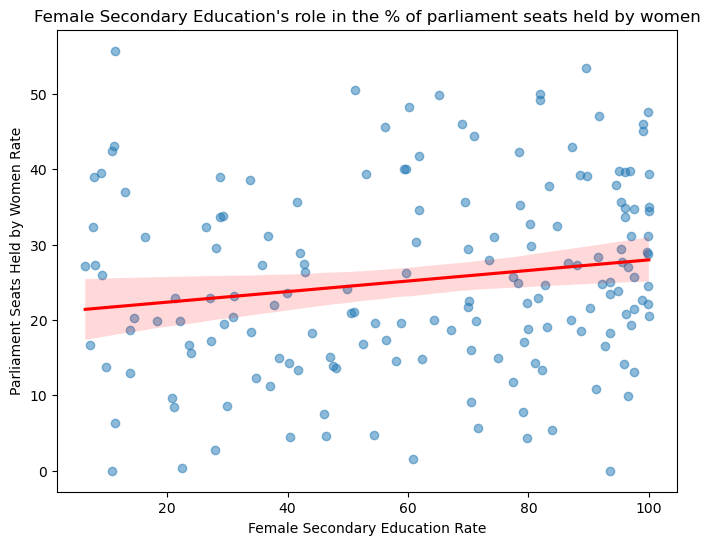

In [20]:
# Creating the scatter plot with the regression line (model 1)
plt.figure(figsize=(8, 6))
sns.regplot(x=df['femalesecondaryeducation'], y=df['parliamentseatsheldbywomenrate'], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Customizing the titles and labels
plt.title("""Female Secondary Education's role in the % of parliament seats held by women""")
plt.xlabel('Female Secondary Education Rate')
plt.ylabel('Parliament Seats Held by Women Rate')

# Showing the plot
plt.show()

### Model 2: % of seats held by women in the parliament on female secondary education rate and GII (z1)

$parliamentseats=\beta_0 + \beta_1 femalesecondaryeducation + \beta_2 GII$

The second model studies how the female secondary education and the Gender Inequality Index combined have an overall impact on the seats held in the parliament. (**Appendix B1**) All covariates are significant at 99%. $\beta_1$ of this model indicates that for a one-unit increase in female secondary education rates, and while holding the GII constant, the model predicts a decrease in the percentage of seats held by women in parliament by 0.208 units. The CI of the slope is [-0.295;-0.121] not including zero. Conditioning on z1, $\beta_2$ shows that for a one-unit increase in the GII, and while holding female secondary education constant, the model predicts a decrease in the percentage of seats held by women in parliament by 52.114 units. The two variables' CIs don't overlap, suggesting a statistically significant difference. The robust SE of this coefficient is significantly higher (6.409) than the SE of $\beta_1$, meaning that it might be less reliable or more sensitive to variations in the data compared to $\beta_1$. R-squared is 0.267, meaning that by taking GII into consideration, we increase the model's goodness of fit. To identify further potential nonlinear relationships, I analyzed the second model with a lowess method and found a similar pattern to Model 1 (decrease between 20% and 40%). (**Appendix B2**)

In [21]:
# Creating the regressions with the dependent and z1 conditioning variables
reg2 = smf.ols(formula="parliamentseatsheldbywomenrate~femalesecondaryeducation+gii", data=df).fit(cov_type="HC1")

### Model 3: % of seats held by women in the parliament on female secondary education rate and female labour force rate (z2)

$parliamentseats=\beta_0 + \beta_1 femalesecondaryeducation + \beta_2 femalelabourforce$

The third model examines how the female secondary education and the Female labour force participation rate combined have an overall impact on the seats held in the parliament. (**Appendix B3**) All covariates are significant at 99% except for $\beta_0$ which is significant at 95%. $\beta_1$ showss a one-unit increase in female secondary education rates, and while holding the female labour force rate constant, the model predicts a 8.2% increase in the percentage of seats held by women in parliament. The CI of the $\beta_1$ is [0.023;0.142]. $\beta_2$ suggests that for a one-unit increase in the female labour force, and while holding female secondary education constant, the model predicts a 24.1% increase in the percentage of seats held by women in parliament. The CI of the slope is [0.130;0.352], meaning that we can be 95% confident that the true effect of the of the female labour force rate, while holding the female secondary education rate constant, on the percentage of seats held by women in parliament is between 13% and 35.2%. R-squared is higher than the R-squared only considering the female secondary education (0.117), but not higher when we only take the GII into consideration (0.259).

In [22]:
# Creating the regressions with the dependent and z2 conditioning variables
reg3 = smf.ols(formula="parliamentseatsheldbywomenrate~femalesecondaryeducation+femalelabourforce", data=df).fit(cov_type="HC1")

### Model 4: % of seats held by women in the parliament on female secondary education rate, GII (z1) and female labour force rate (z2)

$parliamentseats=\beta_0 + \beta_1 femalesecondaryeducation + \beta_2 GII + \beta_3 femalelabourforce$

This model challenges the assumptions about the direct relationships between all the variables and their correlation between parliament seats. (**Appendix C1**) All covariates are significant at 99%. $\beta_1$ indicates that the model predicts a 1.4% increase in the percentage of seats held by women in parliament considering female secondary education. The confidence interval of the slope is [-0.259;-0.088] which does not include zero. None of the confidence intervals overlap, indicating a statistically significant difference between the variables. (**Appendix C2**) This particular regression model exhibits the highest R-squared value among all the examined models, indicating the strongest explanatory power in explaining the variation (0.299). This means that by taking all the variables into consideration, we increase our model's goodness of fit.

In [23]:
# Creating the regressions with the dependent and both (z1 and z2) conditioning variables
reg4 = smf.ols(formula="parliamentseatsheldbywomenrate~femalesecondaryeducation+gii+femalelabourforce", data=df).fit(cov_type="HC1")

To broaden the scope of understanding gender disparities, **Appendix D** shows a distribution of parliament seats by the Human Development Index (HDI). My expectations were skewed distributions with right long tails, but surprisingly, distributions for all HDI categories are normal, only slightly skewed to the right as the HDI level increases.

## 4. Probability calculation

Upon checking the linear probability model (LPM), I concluded that the spread of the prediction goes well above 1 (39.3141) which means that we need to use logit and probit models to get accurate predicted probability values. (**Appendix E1**)

### Interpretation for logit

- A one-unit increase in female secondary education is associated with an approximate decrease of 0.0063 in the log odds of being above the threshold (holding other variables constant). The effect is statistically significant (p < 0.05)
- A one-unit increase in the Gender Inequality Index (GII) is associated with an approximate decrease of 1.5492 in the log odds of being above the threshold (holding other variables constant). The effect is highly statistically significant (p < 0.001).
- A one-unit increase in female labor force participation rate is associated with an approximate increase of 0.0051 in the log odds of being above the threshold (holding other variables constant). The effect is statistically significant (p < 0.05).

### Interpretation for probit
- Almost same results as the results as of logit, however, far from LPM.

In [24]:
# Dropping rows with NaN values in any column
cleaned_df = df.dropna()

# Generating predictions for the cleaned dataset
cleaned_df["pred_lpm4"] = reg4.predict(cleaned_df)

# Checking the spread of parliament seats
df.parliamentseatsheldbywomenrate.describe()
# Based on the values, we can conclude that the maximum percentage is 55.7%, therefore it makes sense to set the threshold to 25%

# Creating a binary variable based on the threshold (25%)
threshold = 25
cleaned_df['above_threshold'] = (cleaned_df['parliamentseatsheldbywomenrate'] > threshold).astype(int)

# Estimating the logit model of reg4
y, X = dmatrices(
    "above_threshold ~ femalesecondaryeducation + gii + femalelabourforce",
    cleaned_df,
)
logit_mod = sm.Logit(y, X)
logit_res = logit_mod.fit()
logit_margeff_results = logit_res.get_margeff()
logit_margeff_results.summary()

Optimization terminated successfully.
         Current function value: 0.585512
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:        above_threshold
Method:                          dydx
At:                           overall
============================================================================================
                              dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
femalesecondaryeducation    -0.0063      0.002     -3.103      0.002      -0.010      -0.002
gii                         -1.5492      0.275     -5.635      0.000      -2.088      -1.010
femalelabourforce            0.0051      0.002      2.124      0.034       0.000       0.010
============================================================================================
"""

In [25]:
# Estimating the probit model of reg4
probit = sm.Probit(y, X)
probit_res = probit.fit()
probit_margeff_results = probit_res.get_margeff()
probit_margeff_results.summary()

Optimization terminated successfully.
         Current function value: 0.585214
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:        above_threshold
Method:                          dydx
At:                           overall
============================================================================================
                              dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
femalesecondaryeducation    -0.0065      0.002     -3.216      0.001      -0.010      -0.003
gii                         -1.5773      0.276     -5.717      0.000      -2.118      -1.037
femalelabourforce            0.0049      0.002      2.094      0.036       0.000       0.009
============================================================================================
"""

In [26]:
# Adding the probit and logit predictions to the clea_df
cleaned_df["pred_probit"] = probit_res.predict()
cleaned_df["pred_logit"] = logit_res.predict()

# Showing information for the predicted values for conclusion
cleaned_df.pred_probit.describe()

count    170.000000
mean       0.467368
std        0.220753
min        0.011524
25%        0.289622
50%        0.450711
75%        0.656586
max        0.904248
Name: pred_probit, dtype: float64

In [27]:
cleaned_df.pred_logit.describe()

count    170.000000
mean       0.464706
std        0.220112
min        0.023174
25%        0.286568
50%        0.444454
75%        0.659849
max        0.892147
Name: pred_logit, dtype: float64

### Interpreting goodness of fit measures (Appendix E2)

- The Brier scores suggest that the models perform very similarly, with logit (0.2011) and probit (0.2012) providing the best fit.
- LPM has a higher Brier score of 659.618 suggesting a significantly worse fit.
- The log-loss values of each model show the similar ordering: logit and probit model show very similar results (-0.5855 and -0.5852 respectively).
- LPM has a higher log-loss absolute value, performing lower than logit and probit.
- The prediction values of only the logit and probit models are correctly bound between 0 and 1.

----------------------------------------------------------------------------------------------------------------------
## 5. Conclusion

The study uncovers key relationships between socio-economic factors and women's representation in parliamentary seats. To enhance female representation, and considering the strong correlation between secondary education and % of seats, nations should invest and ensure comprehensive and accessible educational opportunities for women accross all demographics. The tackle the matter of significant impact of GII on parliamentary seats, I would suggest targeted policies promoting gender equity in healthcare, workforce participation which could contribute to a more equitable political landscape. In the case of labour force - as it has also significant (24.1% increase) - impact, I would recommend providing parental leave, affordable childcare, promoting flexible work arrangements, and prividing equal career development opportunities for all genders.

## 6. Main summary and limitations

The analysis revealed a strong correlation between female secondary education rates and parliamentary seats held by women, with a 1% increase in education linked to a 7.01% rise in representation. Notably, this relationship diminished between 20% and 40% education rates. Conversely, higher Gender Inequality Index (GII) values corresponded to a significant decrease (52.114 units) in women's parliamentary representation per GII unit increase. Moreover, a 1% rise in female labor force participation correlated with a 24.11% increase in parliamentary seats held by women, showcasing the empowerment of increased workforce participation. While logit and probit models align closely with actual outcomes, the LPM model underperforms. The study's limitations encompass missing data resulting in incomplete country representation. Additionally, the Gender Inequality Index (GII) values' interpretation was challenging due to high standard errors (6.409).

-----------------------------------------------------------------------------------------------------------------------
## References

- World Data of Gender Inequality index (2023) Kaggle. Available at: https://www.kaggle.com/datasets/rajkumarpandey02/world-data-of-gender-inequality-index (Accessed: 21 December 2023). 
- Nations, U. (no date) Documentation and downloads, Human Development Reports. Available at: https://hdr.undp.org/data-center/documentation-and-downloads (Accessed: 21 December 2023). 

## Appendices

### Appendix A1. (Model 1)

In [28]:
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     parliamentseatsheldbywomenrate   R-squared:                       0.029
Model:                                        OLS   Adj. R-squared:                  0.023
Method:                             Least Squares   F-statistic:                     4.850
Date:                            Fri, 22 Dec 2023   Prob (F-statistic):             0.0290
Time:                                    16:03:32   Log-Likelihood:                -665.59
No. Observations:                             170   AIC:                             1335.
Df Residuals:                                 168   BIC:                             1341.
Df Model:                                       1                                         
Covariance Type:                              HC1                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   20.9519      2.270      9.231      0.000      16.503      25.401
femalesecondaryeducation     0.0701      0.032      2.202      0.028       0.008       0.132
==============================================================================
Omnibus:                        3.489   Durbin-Watson:                   1.608
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                3.034
Skew:                           0.235   Prob(JB):                        0.219
Kurtosis:                       2.544   Cond. No.                         159.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Appendix A2. (Model 1 with lowess method)

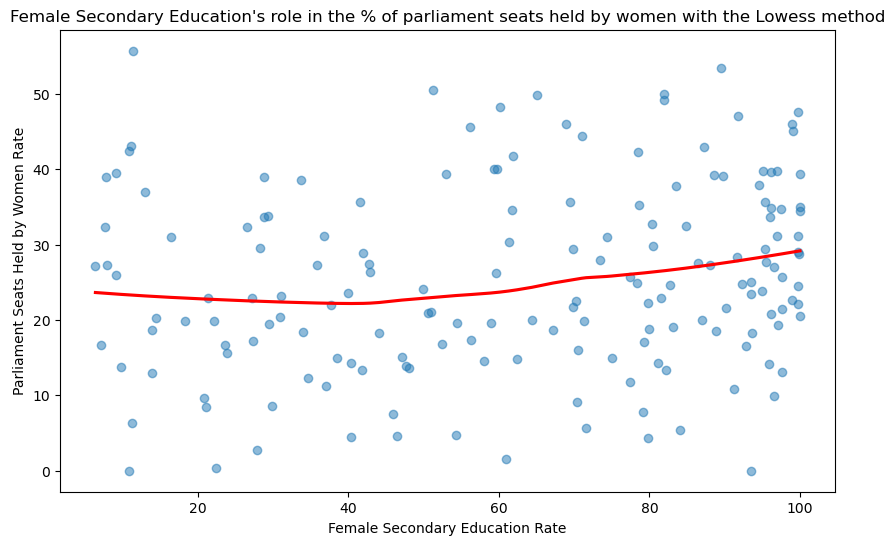

In [29]:
# Creating the scatter plot with the regression line with the lowess method
plt.figure(figsize=(10, 6))
sns.regplot(x=df['femalesecondaryeducation'], y=df['parliamentseatsheldbywomenrate'], lowess = True, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Customizing the titles and labels
plt.title("""Female Secondary Education's role in the % of parliament seats held by women with the Lowess method""")
plt.xlabel('Female Secondary Education Rate')
plt.ylabel('Parliament Seats Held by Women Rate')

# Showing the plot
plt.show()

### Appendix B1 (Model 2 regression table)

In [30]:
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     parliamentseatsheldbywomenrate   R-squared:                       0.267
Model:                                        OLS   Adj. R-squared:                  0.259
Method:                             Least Squares   F-statistic:                     40.07
Date:                            Fri, 22 Dec 2023   Prob (F-statistic):           6.11e-15
Time:                                    16:03:33   Log-Likelihood:                -641.62
No. Observations:                             170   AIC:                             1289.
Df Residuals:                                 167   BIC:                             1299.
Df Model:                                       2                                         
Covariance Type:                              HC1                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   56.1784      4.894     11.479      0.000      46.586      65.770
femalesecondaryeducation    -0.2083      0.044     -4.686      0.000      -0.295      -0.121
gii                        -52.1136      6.409     -8.132      0.000     -64.674     -39.553
==============================================================================
Omnibus:                        2.486   Durbin-Watson:                   1.635
Prob(Omnibus):                  0.289   Jarque-Bera (JB):                2.240
Skew:                           0.280   Prob(JB):                        0.326
Kurtosis:                       3.053   Cond. No.                         726.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Appendix B2 (Model 2 with lowess method)

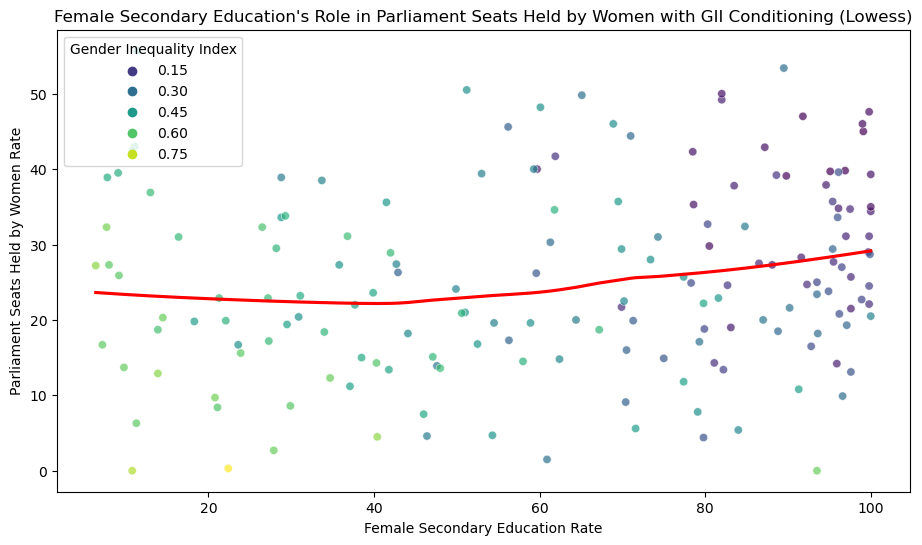

In [31]:
# Creating the scatter plot with the regression line and color-coded GII values
plt.figure(figsize=(11, 6))
sns.scatterplot(x=df['femalesecondaryeducation'], y=df['parliamentseatsheldbywomenrate'], hue=df['gii'], palette='viridis', alpha=0.7)
sns.regplot(x=df['femalesecondaryeducation'], y=df['parliamentseatsheldbywomenrate'], scatter=False, lowess=True, line_kws={'color': 'red'})

# Customizing the titles and labels
plt.title("Female Secondary Education's Role in Parliament Seats Held by Women with GII Conditioning (Lowess)")
plt.xlabel('Female Secondary Education Rate')
plt.ylabel('Parliament Seats Held by Women Rate')

# Adding a legend
plt.legend(title='Gender Inequality Index')

# Showing the plot
plt.show()

### Appendix B3 (Model 3 regression table)

In [32]:
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     parliamentseatsheldbywomenrate   R-squared:                       0.117
Model:                                        OLS   Adj. R-squared:                  0.106
Method:                             Least Squares   F-statistic:                     12.37
Date:                            Fri, 22 Dec 2023   Prob (F-statistic):           9.76e-06
Time:                                    16:03:33   Log-Likelihood:                -657.49
No. Observations:                             170   AIC:                             1321.
Df Residuals:                                 167   BIC:                             1330.
Df Model:                                       2                                         
Covariance Type:                              HC1                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    8.0559      3.617      2.227      0.026       0.966      15.146
femalesecondaryeducation     0.0823      0.030      2.716      0.007       0.023       0.142
femalelabourforce            0.2411      0.057      4.249      0.000       0.130       0.352
==============================================================================
Omnibus:                        3.931   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                3.405
Skew:                           0.257   Prob(JB):                        0.182
Kurtosis:                       2.534   Cond. No.                         352.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Appendix C1 (Regression tables)

In [33]:
stargazer = Stargazer([reg1, reg2, reg3, reg4])
stargazer.custom_columns(["femalesecondaryeducation", "gii", "femalelabourforce", 'Intercept'])
stargazer.covariate_order(["femalesecondaryeducation", "gii", "femalelabourforce", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

### Appendix C2 (Model 4 regression table)

In [34]:
reg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     parliamentseatsheldbywomenrate   R-squared:                       0.299
Model:                                        OLS   Adj. R-squared:                  0.286
Method:                             Least Squares   F-statistic:                     30.39
Date:                            Fri, 22 Dec 2023   Prob (F-statistic):           1.03e-15
Time:                                    16:03:33   Log-Likelihood:                -637.90
No. Observations:                             170   AIC:                             1284.
Df Residuals:                                 166   BIC:                             1296.
Df Model:                                       3                                         
Covariance Type:                              HC1                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   44.8109      5.936      7.548      0.000      33.176      56.446
femalesecondaryeducation    -0.1738      0.044     -3.977      0.000      -0.259      -0.088
gii                        -47.0661      6.330     -7.436      0.000     -59.472     -34.660
femalelabourforce            0.1487      0.051      2.924      0.003       0.049       0.248
==============================================================================
Omnibus:                        3.397   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.183   Jarque-Bera (JB):                3.014
Skew:                           0.316   Prob(JB):                        0.222
Kurtosis:                       3.162   Cond. No.                         978.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Appendix D (KDE considering HDI levels)

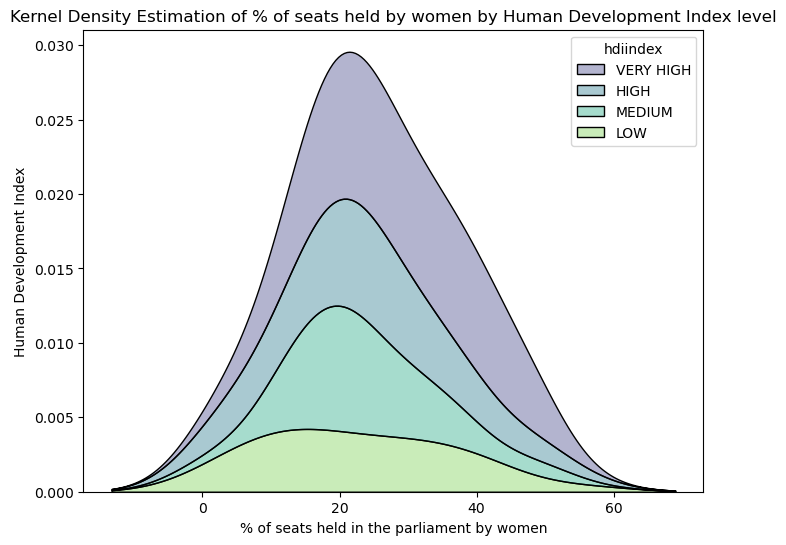

In [35]:
# Setting the chart size
plt.figure(figsize=(8, 6))

# Creating a KDE plot
sns.kdeplot(data = df, x = "parliamentseatsheldbywomenrate", hue = "hdiindex",
           palette = 'viridis',
           fill = True,
           alpha = 0.4,
           multiple="stack")

# Setting labels and title
plt.xlabel("% of seats held in the parliament by women")
plt.ylabel("Human Development Index")
plt.title("Kernel Density Estimation of % of seats held by women by Human Development Index level")
plt.show()

### Appendix E1 (LPM prediction values)

In [36]:
# Checking the spread of the predicted values (min, max)
cleaned_df["pred_lpm4"].describe().round(4)

count    170.0000
mean      25.3035
std        6.7512
min        3.2165
25%       20.7910
50%       25.4160
75%       30.2688
max       39.3141
Name: pred_lpm4, dtype: float64

### Appendix E2 (Goodness of fit scores)

In [37]:
p1 = pd.DataFrame(
    {
        "Brier-score": [
            mean_squared_error(cleaned_df["above_threshold"], cleaned_df["pred_lpm4"]),
            mean_squared_error(cleaned_df["above_threshold"], cleaned_df["pred_logit"]),
            mean_squared_error(cleaned_df["above_threshold"], cleaned_df["pred_probit"]),
        ], "Log-loss": [
            -1 * log_loss(cleaned_df["above_threshold"], cleaned_df["pred_lpm4"]),
            -1 * log_loss(cleaned_df["above_threshold"], cleaned_df["pred_logit"]),
            -1 * log_loss(cleaned_df["above_threshold"], cleaned_df["pred_probit"]),
        ],
    },
    index=["LPM", "Logit", "Probit"],
).T.round(4)

p1

,LPM,Logit,Probit
Brier-score,659.6177,0.2011,0.2012
Log-loss,-19.2940,-0.5855,-0.5852
